In [1]:
from river import datasets
from river import ensemble
from river import evaluate
from river import linear_model
from river import metrics
from river import optim
from river import preprocessing
from river import drift
import pickle
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

#### Building a chunk-based ensemble 

In [2]:
# Create mini-batch of features and labels
from sklearn.metrics import accuracy_score

labels = list()
features = list()
predictions = list()
def create_mini_batch(feature, label, prediction, chunk_size=5):

    labels.append(label)
    features.append(feature)
    predictions.append(int(prediction))
    
    label_window = pd.Series(labels)[-chunk_size:]
    feature_window = pd.DataFrame(features)[-chunk_size:]
    pred_window = pd.Series(predictions)[-chunk_size:]
    
    accuracy = accuracy_score(label_window, pred_window)
    
    return feature_window, label_window, accuracy

In [3]:
# Initialize Dataset
dataset = datasets.synth.Agrawal(
     classification_function=5,
     seed=42
)

# Loading model pickle file
model = pickle.load(open('saved_model/river_model.pkl', 'rb'))

# Initialise metric
metric = metrics.Accuracy()

# Initialize lists to store data
accuracy_buffer_1 = list()
ensemble = list()

# define chunk size
chunk_size = 1000

for i,data in enumerate(dataset.take(16000)):
    # data[0] - features, data[1] - label
    outputs = list()
    if ensemble:
        for model in ensemble:
            pred = model.predict_one(data[0])
            outputs.append(pred)
        count = Counter(outputs)
        y_pred = count.most_common()[0][0]
    
    y_pred = model.predict_one(data[0])
    metric = metric.update(data[1],y_pred)
    feature_buffer,label_buffer, accuracy = create_mini_batch(data[0],data[1],y_pred,chunk_size)
    
    if i%chunk_size==0:
        accuracy_buffer_1.append(accuracy)
        print(f'Index {i}')
        print(f'Training a new model with chunk size: {len(feature_buffer)}')
        new_model = 'model_'+str(i)
        new_model = (
                    preprocessing.StandardScaler() |
                    linear_model.LogisticRegression(optimizer=optim.SGD(.1))
                        )
        new_model.learn_many(feature_buffer,label_buffer)
        ensemble.append(new_model)

Index 0
Training a new model with chunk size: 1
Index 1000
Training a new model with chunk size: 1000
Index 2000
Training a new model with chunk size: 1000
Index 3000
Training a new model with chunk size: 1000
Index 4000
Training a new model with chunk size: 1000
Index 5000
Training a new model with chunk size: 1000
Index 6000
Training a new model with chunk size: 1000
Index 7000
Training a new model with chunk size: 1000
Index 8000
Training a new model with chunk size: 1000
Index 9000
Training a new model with chunk size: 1000
Index 10000
Training a new model with chunk size: 1000
Index 11000
Training a new model with chunk size: 1000
Index 12000
Training a new model with chunk size: 1000


In [ ]:
# Overall Accuracy
print(metric)

Accuracy: 51.58%


In [ ]:
# Total number of chunks
# dataset size 16000
16000/chunk_size

16.0

In [ ]:
# Total ensemble models 
len(ensemble)

16

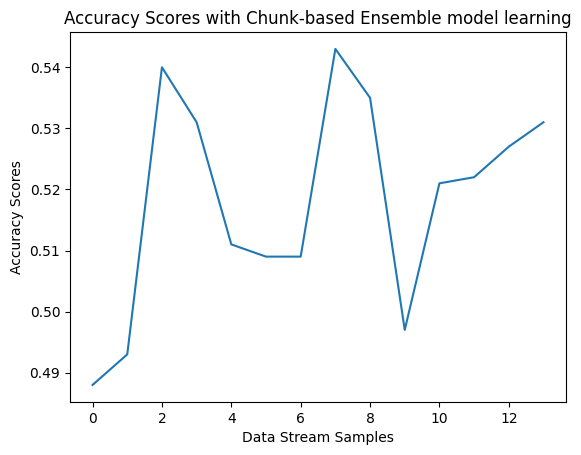

In [ ]:
def plot():
    plt.plot(accuracy_buffer_1[2:])
    plt.xlabel('Data Stream Samples')
    plt.ylabel('Accuracy Scores')
    plt.title('Accuracy Scores with Chunk-based Ensemble model learning')
    plt.show()
plot()

#### Building a drift-based ensemble 

In [ ]:
# Initialize Dataset
dataset = datasets.synth.Agrawal(
     classification_function=5,
     seed=42
)

# Initialie the ADWIN drift detector
drift_detector = drift.ADWIN(delta=1.5)
drifts = []

# Loading model pickle file
model = pickle.load(open('saved_model/river_model.pkl', 'rb'))

# Initialise metric
metric = metrics.Accuracy()

# Initialize list to store data
feature_buffer = list()
label_buffer = list()
pred_buffer = list()
ensemble = list()
accuracy_list = list()

for i,data in enumerate(dataset.take(16000)):
    # data[0] - features, data[1] - label
    outputs = list()
    if ensemble:
        print(f'Total ensemble model: {len(ensemble)}')
        for model in ensemble:
            pred = model.predict_one(data[0])
            outputs.append(pred)
        print(outputs)
        count = Counter(outputs)
        y_pred = count.most_common()[0][0]
        print(y_pred)
    y_pred = model.predict_one(data[0])
    metric = metric.update(data[1],y_pred)
    # Updating buffers for training new model
    feature_buffer.append(data[0])
    label_buffer.append(data[1])
    pred_buffer.append(int(y_pred))
    # Updating drift detector
    drift_detector.update(y_pred == data[1])
    # The drift detector indicates after each sample if there is a drift in the data
    if drift_detector.drift_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i}')
        drifts.append(i)
        # Creating dataframe for features and labels
        features = pd.DataFrame(feature_buffer)
        labels = pd.Series(label_buffer)
        predictions = pd.Series(pred_buffer)
        accuracy_list.append(accuracy_score(labels, predictions))
        print(f'Training a new model with samples: {len(feature_buffer)}')
        feature_buffer = list()
        label_buffer = list()
        pred_buffer = list()
        new_model = 'model_'+str(i)
        new_model = (preprocessing.StandardScaler() |
                        linear_model.LogisticRegression(optimizer=optim.SGD(.1))
                        )
        new_model.learn_many(features,labels)
        ensemble.append(new_model)

Change detected at index 191
Training a new model with samples: 192
Total ensemble model: 1
[False]
False
Total ensemble model: 1
[True]
True
Total ensemble model: 1
[True]
True
Total ensemble model: 1
[False]
False
Total ensemble model: 1
[False]
False
Total ensemble model: 1
[True]
True
Total ensemble model: 1
[True]
True
Total ensemble model: 1
[False]
False
Total ensemble model: 1
[False]
False
Total ensemble model: 1
[True]
True
Total ensemble model: 1
[False]
False
Total ensemble model: 1
[False]
False
Total ensemble model: 1
[True]
True
Total ensemble model: 1
[False]
False
Total ensemble model: 1
[True]
True
Total ensemble model: 1
[True]
True
Total ensemble model: 1
[True]
True
Total ensemble model: 1
[False]
False
Total ensemble model: 1
[False]
False
Total ensemble model: 1
[False]
False
Total ensemble model: 1
[True]
True
Total ensemble model: 1
[True]
True
Total ensemble model: 1
[False]
False
Total ensemble model: 1
[True]
True
Total ensemble model: 1
[False]
False
Total 

In [ ]:
# Overall accuracy
print(metric)

Accuracy: 51.80%


In [ ]:
# Total drift detected
len(drifts)

17

In [ ]:
# Total number of models in ensemble
len(ensemble)

17

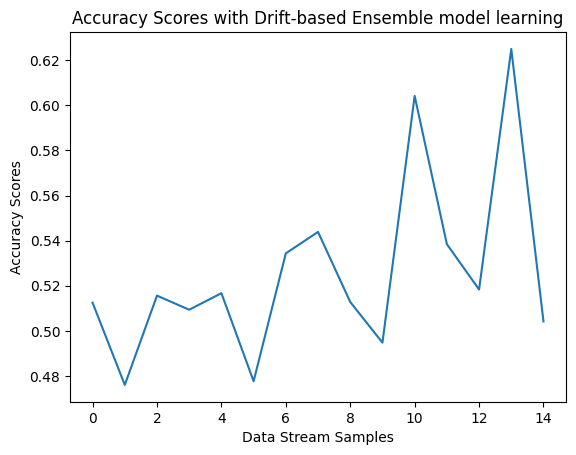

In [ ]:
def plot():
    plt.plot(accuracy_list[2:])
    plt.xlabel('Data Stream Samples')
    plt.ylabel('Accuracy Scores')
    plt.title('Accuracy Scores with Drift-based Ensemble model learning')
    plt.show()
plot()